# Generative Learning With Pytorch: Fashion MNIST

## Introduction

One of the most interesting developments of deep learning in recent years has been that of the generative adversarial network, an unsupervised machine learning algorithm for producing new data. Applications of this technique include producing convincing images of things which don't actually exists, such as people, places and objects, increasing image resolution, producing text, and augmenting datasets.

## How does it work?

Generative adversarial learning might be best described by way of analogy. Consider an artist, Germaine Generator, and his friend Dani Discriminator. Germaine is very good at reproducing the works of early 19th century French painter Theodore Gericault, and Dani is an expert on Romantic movement art. Germaine wasn't always good at painting though. When he started, he was terrible. Germaine improved his work by inviting Dani to classify a painting as either an authentic Gericault, or one of his reproductions. If Dani classifies the work as a reproduction, Germaine goes back and makes minor adjustments to his painting, then repeats the process. Repeated enough times, Germaine might improve so much that he can paint reproductions which Dani may not be able to discriminate from the real thing.

GANs work in the same way. We have a generator network which produces 'fake' images from randomly generated noise. This fake image is presented to the discriminator network, which has previously been trained on 'real' images, and the discriminator provides feedback on the fake image in the form of a probability that it would be classified as real. The generator network then goes back and makes slight changes to its parameters, and tries again. Repeated enough times, this process will turn randomly generated noise into something closely resembling a 'real' thing. 

## The Project

The Fashion-MNIST data set is a library of 70,000 images of Zalando clothing (60K train, 10K test). The images are formatted as 28 x 28 grayscale for ease of use in machine learning applications. The aim of this project is to construct a GAN using the DCGAN architecture to produce images of clothing which don't actually exist. Then a separate classifier will be built to attempt to identify the class of each fake image. We will be using the Pytorch package for Python, and the project will be run on Google's 'colab'. 

## Setting Up the Network 

**Step 1:** Import libraries, define constants and set device.

In [1]:
import torch
from torch import optim
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.conv import ConvTranspose2d
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

CODING_SIZE = 100
BATCH_SIZE = 32
IMAGE_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

**Step 2:** Data preparation, loading, and batching. 

The Fashion-MNIST dataset is available within the torchvision datasets module, but to be useful to our Pytorch network these images must be transformed into tensors. Tensors in this context are multi-dimensional arrays which Pytorch uses as its fundamental data structure. The Dataloader class allows us to sample batches of the dataset to present to the network as needed. 

In [ ]:
# Define tensor transformation
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

# Load dataset
dataset = datasets.FashionMNIST('./', train = True, download = True, transform = transform)

# Create dataloader for batch iteration
dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

**Step 3:** Now that we've loaded the data, let's have a look at a batch of real Fashion-MNIST images. As we can see, these are low resolution, grayscale images of random items of clothing and footwear. Not much to look at, but they are easy to work with. 

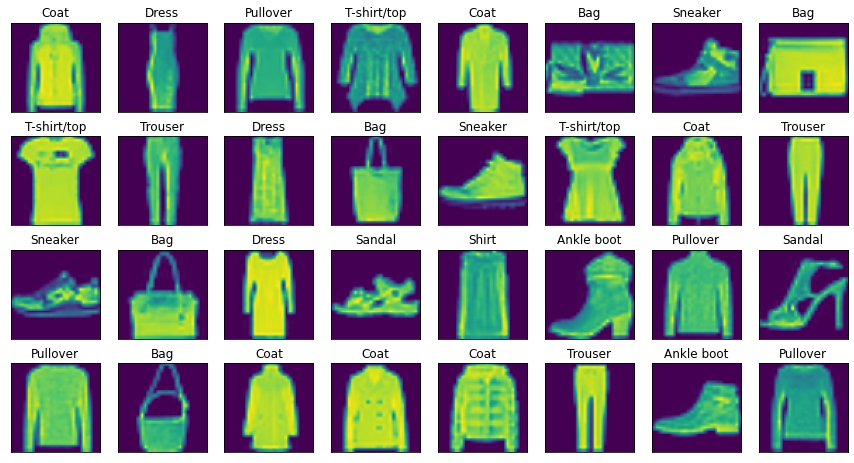

In [3]:
# Define class labels 
fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

# Obtain a batch of images from the dataloader
data_batch, labels_batch = next(iter(dataloader))

# Plot the batch of images
fig=plt.figure(figsize=(15,8))
for i in range(len(labels_batch)):
    ax=fig.add_subplot(4,8,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(data_batch[i]))
    ax.set_title(f"{fashion_class[labels_batch[i].item()]}")


**Step 4:** Model Design.

The network class is the core of the Pytorch deep learning model. It is where we define the architecture of the neural network, the structure of the layers, the activation functions, and any other function we may wish to apply within the neural network itself. There are a number of different ways to write these modules, in this case we've adopted a sequential setup. We require two such classes for a GAN; a generator and a discriminator. 

Generator network:

The generator is the opposite of an image classifier; it takes an input of 100 random values and creates an image from them. At each layer of this network, we perform a transposed convolution on the input, normalise it, and apply an activation function. 

In [4]:
class Generator(nn.Module):
  def __init__(self, coding_sz):
    super(Generator, self).__init__()
    self.net = nn.Sequential(
        nn.ConvTranspose2d(coding_sz, 1024, 4, 1, 0),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.ConvTranspose2d(1024, 512, 4, 2 ,1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(512, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 1, 4 , 2, 1),
        nn.Tanh()
    )

  def forward(self, input):
    return self.net(input)

netG = Generator(CODING_SIZE).to(device)

**Step 5:** Model Design: Discriminator network. 

The discriminator class is a binary classification network determining the probability that image presented to it is real. It is structurally similar to other familiar image classification architectures, using layers of convolutional networks. 

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 128, 4, 2, 1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256, 512, 4, 2, 1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),
        nn.Conv2d(512, 1024, 4, 2, 1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, 4, 1, 0),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.net(input)

netD = Discriminator().to(device)

**Step 6:** Connected neurons within neural networks have 'weights' attached to them, which function as a multiplicative factor for the data passing through. It is these weights that the backpropagation algorithm adjusts in order to optimise the network with respect to some objective function (loss function). These weights must begin as some small, random, non-zero number.

In [ ]:
# Initialise network weights
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

## Training the network

**Step 7:** Setting loss and optimisers.

For the purposes of binary classification we desire an objective function which will minimise the probability of an erroneous classification. The binary cross entropy function is perfectly suited to the task of quantifying the difference between the input target value and actual value as a value between 0 and 1, which we may interpret as a probability, hence we employ this as our 'loss' function. 

The optimiser is the algorithm which adjusts the network weights given the output of the loss function. Conceptually, the simplest such algorithm is gradient descent, which takes the partial derivative of the loss function with respect to the network weights. This partial derivative is multiplied by some learning rate backpropagated through the network to adjust the weights. In this case, we choose a more sophisticated optimiser, 'Adam', short for adaptive moment estimation, which speeds up the training process by maintaining a running average of gradients.


In [7]:
# Loss function
criterion = nn.BCELoss()

# Optimiser for each network
optimiserG = optim.Adam(netG.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimiserD = optim.Adam(netD.parameters(), lr = 0.0001, betas=(0.5, 0.999))

# Label tensors
real_labels = torch.full((BATCH_SIZE,), 1., dtype=torch.float, device = device)
fake_labels = torch.full((BATCH_SIZE,), 0., dtype=torch.float, device = device)

# Storage lists for errors and results
G_losses = []
D_losses = []
D_real = []
D_fake = []

# Test vector
z = torch.randn((BATCH_SIZE, 100)).view(-1, 100, 1, 1).to(device)
test_out_images = []

**Step 8:** Implement the training loop.

In [ ]:
N_EPOCHS = 4

for epoch in range(N_EPOCHS):
  print(f'Epoch: {epoch}')
  for i, batch in enumerate(dataloader):
    if (i%200==0):
      print(f'batch: {i} of {len(dataloader)}')
    
    # Train discriminator with batch of real images.
    netD.zero_grad()
    real_images = batch[0].to(device) *2. -1.
    output = netD(real_images).view(-1)
    errD_real = criterion(output, real_labels)
    D_x = output.mean().item()

    # Train discriminator with batch of fake images.
    noise = torch.randn((BATCH_SIZE, CODING_SIZE))
    noise = noise.view(-1, 100, 1, 1).to(device)
    fake_images = netG(noise)
    output = netD(fake_images).view(-1)
    errD_fake = criterion(output, fake_labels)
    D_G_z1 = output.mean().item()
    errD = errD_real + errD_fake
    
    # Run backprop, update discriminator
    errD.backward(retain_graph = True)
    optimiserD.step()

    # Train generator to produce better fakes
    netG.zero_grad()
    output = netD(fake_images).view(-1) # Pass fakes to updated discriminator
    
    # Generator loss determined by cases where discriminator is wrong
    errG = criterion(output, real_labels) 
    
    # Backprop, update generator
    errG.backward()
    D_G_z2 = output.mean().item()
    optimiserG.step()

    if (epoch==0) and (i%375==0):
      # Create batch of images at various stages in epoch 1
      test_images = netG(z).to('cpu').detach()
      test_out_images.append(test_images)
      grid_img = make_grid((test_images+1.)/2., nrow=8)
      plt.imshow(grid_img.permute(1, 2, 0))
      plt.savefig('epoch1_it%d.png' % (i))

  # Save losses for plotting
  G_losses.append(errG.item())
  D_losses.append(errD.item())
  D_real.append(D_x)
  D_fake.append(D_G_z2)

  # Create batch of images at various stages in epoch 1
  test_images = netG(z).to('cpu').detach()
  test_out_images.append(test_images)
  grid_img = make_grid((test_images+1.)/2., nrow=8)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.savefig('epoch%d.png' % (epoch+1))


## GAN Results

With training of the GAN complete, now we may wish to inspect some plots demonstrating the evolution of the generative network, and the final result:

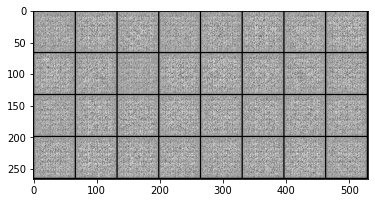

In [9]:
# First iteration (random noise)
grid_img = make_grid((test_out_images[0]+1.)/2.,
                     nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

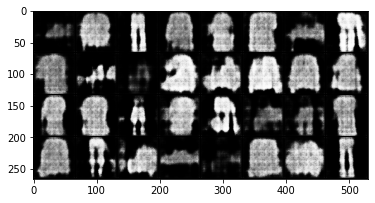

In [10]:
# Epoch 1: Iteration 375
grid_img = make_grid((test_out_images[1]+1.)/2.,
                     nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

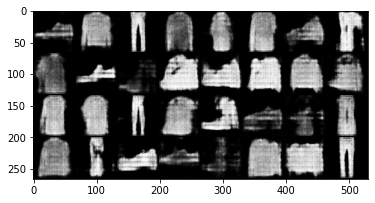

In [11]:
# Epoch 1: Iteration 750
grid_img = make_grid((test_out_images[2]+1.)/2.,
                     nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

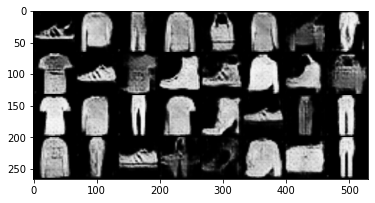

In [13]:
# Final Result, end of epoch 4.
grid_img = make_grid((test_out_images[8]+1.)/2.,
                     nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

## Building a classifier

With our newly generated batch of 32 'fake' images, the next step in this project is to build a classifier trained on the Fashion MNIST data which will try to identify which of the ten classes of items in the dataset are present in the fake images (the ten classes being T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot).

**Why can't we just use the discriminator we've already built?** 

The discriminator is a binary classifier. It has been trained only to identify if an image is a member of the Fashion-MNIST dataset, not to identify which class a given example belongs to. We need a classifier which will assign an image to one of the ten classes of clothing.

**Step 1** Load Fashion-MNIST Data.

This time we require two datasets, a training and a testing set. Separate dataloaders for each set are required also.

In [14]:
# Define tensor transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(IMAGE_SIZE), 
                                transforms.Normalize((0.5,), (0.5,))])

# Load training dataset
dataset = datasets.FashionMNIST('./', train = True, download = True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

# Load testing datset
test_dataset = datasets.FashionMNIST('./', train = False, download = True, transform = transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, 
                                              num_workers = 2)

**Step 2:** Define Network.

For this task we will use a network similar to the well-known [LeNet architecture](https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/), consisting of two convolutional layers, each with ReLU activation and max pooling layers, a flattening layer, and a fully connected linear layer, to produce a model for classifying the 10 classes of Fashion-MNIST. 

In [15]:
class NetConv(nn.Module):
    def __init__(self):
        super(NetConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding = 2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding = 2)
        self.fc1 = nn.Linear(8192, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim = 1)
        return output
        
net = NetConv().to(device)

**Step 3:** Implement train and test regime to train the model. 

Past experience classifying MNIST datasets has shown that stochastic gradient descent optimiser and negative log likelihood loss function is sufficient for this task. 

In [16]:
# Set optimiser.
optimiser = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

# Set numver of epochs.
N_EPOCHS = 10

# Train / Test loop.
for epoch in range(N_EPOCHS):
    net.train()
    for i, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimiser.step()
    # Test
    net.eval()
    test_loss = 0
    correct = 0
    conf_matrix = np.zeros((10,10)) # initialize confusion matrix
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # determine index with maximal log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # update confusion matrix
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                          target.cpu(),pred.cpu(),labels=[0,1,2,3,4,5,6,7,8,9])
        # print confusion matrix
        if epoch == N_EPOCHS-1:
          np.set_printoptions(precision=4, suppress=True)
          print(type(conf_matrix))
          print(conf_matrix)

    test_loss /= len(test_dataloader.dataset)

    if epoch == N_EPOCHS-1:
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_dataloader.dataset),
          100. * correct / len(test_dataloader.dataset)))



<class 'numpy.ndarray'>
[[918.   0.  11.  16.   2.   1.  47.   0.   5.   0.]
 [  4. 985.   0.   6.   1.   0.   2.   0.   2.   0.]
 [ 31.   1. 829.  11.  67.   0.  60.   0.   1.   0.]
 [ 25.   4.   7. 921.  18.   0.  23.   0.   2.   0.]
 [  2.   1.  31.  29. 883.   0.  54.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 978.   0.  12.   1.   9.]
 [172.   1.  45.  29.  76.   0. 673.   0.   3.   1.]
 [  0.   0.   0.   0.   0.   6.   0. 972.   0.  22.]
 [  2.   0.   1.   3.   3.   2.   2.   3. 983.   1.]
 [  0.   0.   0.   0.   0.   5.   1.  23.   0. 971.]]

Test set: Average loss: 0.2973, Accuracy: 9113/10000 (91%)



**Step 4:** View Results.

Before we test our new classifier against the GAN output, it would be helpful to see what our classifier can actually do. Note that the reported accuracy at the end of ten epochs of training is roughly 91%. We will take a batch of the data, use our model to classify it, and display the batch images along with their predicted and actual labels.

tensor([7, 1, 4, 2, 4, 3, 7, 7, 0, 6, 6, 4, 8, 7, 3, 9, 7, 4, 2, 6, 4, 1, 4, 3,
        1, 6, 8, 7, 6, 9, 4, 1], device='cuda:0')


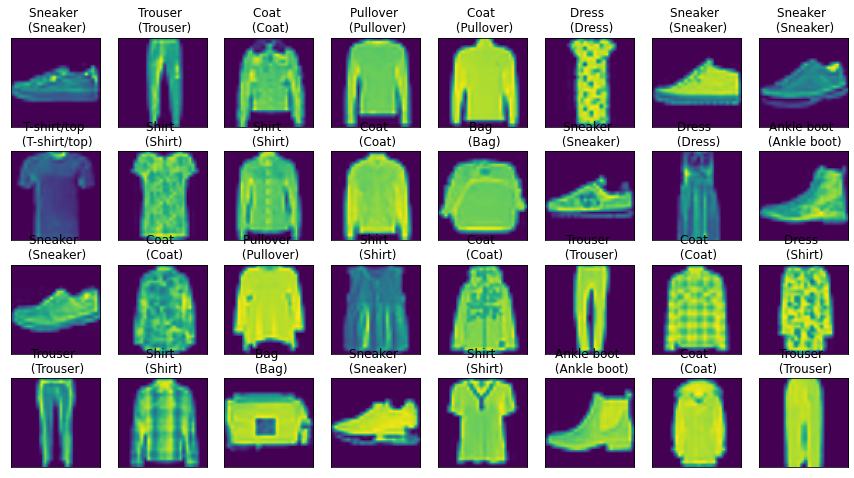

In [17]:
# Get a batch of data
data_batch, labels_batch = next(iter(dataloader))
data_batch, labels_batch = data_batch.to(device), labels_batch.to(device) 

# Send to network to evaluate
net.eval()
output = net(data_batch)

# Obtain predicted class
categoryOutput = torch.argmax(output, 1).to(device)
print(categoryOutput)

# Plot the images, with title of form: 'predicted class (actual class)'
data_batch = data_batch.to("cpu")
fig=plt.figure(figsize=(15,8))
for i in range(len(labels_batch)):
    ax=fig.add_subplot(4,8,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(data_batch[i]))
    ax.set_title(f"{fashion_class[categoryOutput[i].item()]} \n ({fashion_class[labels_batch[i].item()]})")

**Step 5:** Run fake images through classifier.

Finally, we get to find out how our new classifier network see the fake images created by our GAN network.  

tensor([5, 4, 1, 4, 8, 0, 9, 5, 0, 5, 0, 9, 9, 4, 9, 4, 0, 6, 1, 6, 9, 7, 3, 1,
        6, 1, 7, 8, 5, 6, 8, 1], device='cuda:0')


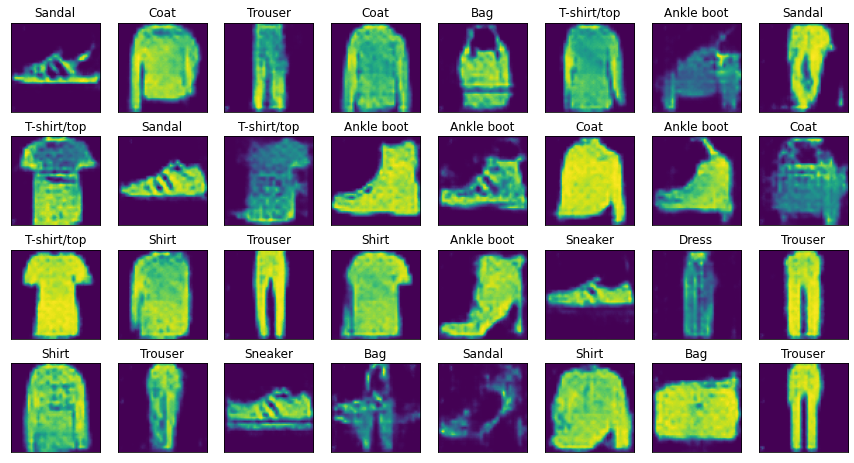

In [18]:
# Get image data from final iteration output of GAN network
fakes = test_out_images[8].to(device)

# Send to network to evaluate
net.eval()
output = net(fakes)

# Obtain predicted class
categoryOutput = torch.argmax(output, 1).to(device)
print(categoryOutput)

# Plot the images, with title of form: 'predicted class (actual class)'
fakes = fakes.to("cpu")
fig=plt.figure(figsize=(15,8))
for i in range(len(fakes)):
    ax=fig.add_subplot(4,8,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(fakes[i]))
    ax.set_title(f"{fashion_class[categoryOutput[i].item()]}")

*Wow!* This is cool. The GAN has produced a lot of very convincing fake images, and the classifier has done a reasonable job at assigning a class to each of these images. Of course, the more interesting cases are where the GAN has produced something vague, such as the two images at the rightmost side of the top row, and the classifier has had to make a choice as to which class it belongs. 


## Acknowledgement
The GAN component of this project is based on the [DCGAN architecture](https://paperswithcode.com/method/dcgan), the Pytorch code for which is largely adapted from [Joe Papa](https://github.com/joe-papa)'s 'Pytorch Pocket Reference'. The classifier component is based on the LeNet architecture, and the code adapted mostly from a university project.   